In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

In [2]:
def esd_test(df_data, max_outliers=None):
    f_t = np.array(df_data.AdjClose.iloc[:])
    window = 10
    g_t = np.ones(int(window))/float(window)
    rolling_mean = np.convolve(f_t, g_t, 'same')
    
    df_data = pd.concat([df_data, pd.DataFrame(rolling_mean, columns=['mean_count'])], axis=1)
    df_data['residual'] = df_data.AdjClose - df_data.mean_count
    
    df_in = df_data[['residual']]
    
    alpha = 0.005
    ind = list(df_in.index)
    x = list(df_in.values)
    outliers = []
    res_lst = [] 
    lam_lst = [] 
    n = len(x)
    
    if max_outliers is None:
        max_outliers = len(x)
        
    for i in range(1,max_outliers+1):
        x_mean = np.mean(x)
        x_std = np.std(x,ddof=1)
        res = abs((x - x_mean) / x_std)
        max_res = np.max(res)
        max_ind = np.argmax(res)
        p = 1 - alpha / (2*(n-i+1))
        t_v = stats.t.ppf(p,(n-i-1)) # Get critical values from t-distribution based on p and n
        lam_i = ((n-i)*t_v)/ np.sqrt((n-i-1+t_v**2)*(n-i+1)) # Calculate critical region (lambdas)
        res_lst.append(max_res)
        lam_lst.append(lam_i)
        if max_res > lam_i:
            outliers.append((ind.pop(max_ind),x.pop(max_ind)))
    # Record outlier Points
    outliers_index = [x[0] for x in outliers]
    
    ESD_stats = pd.DataFrame()
    ESD_stats['ESD Test Statistic'] = res_lst
    ESD_stats['Critical Value'] = lam_lst
    
    return outliers_index

In [3]:
df = pd.read_csv(r'C:\Users\dheer\Desktop\AnomalyDetection\AAPL.csv')
df.tail()

,Date,AdjClose
751,07/05/2021,130.210007
752,10/05/2021,126.849998
753,11/05/2021,125.910004
754,12/05/2021,122.769997
755,13/05/2021,124.970001


No handles with labels found to put in legend.


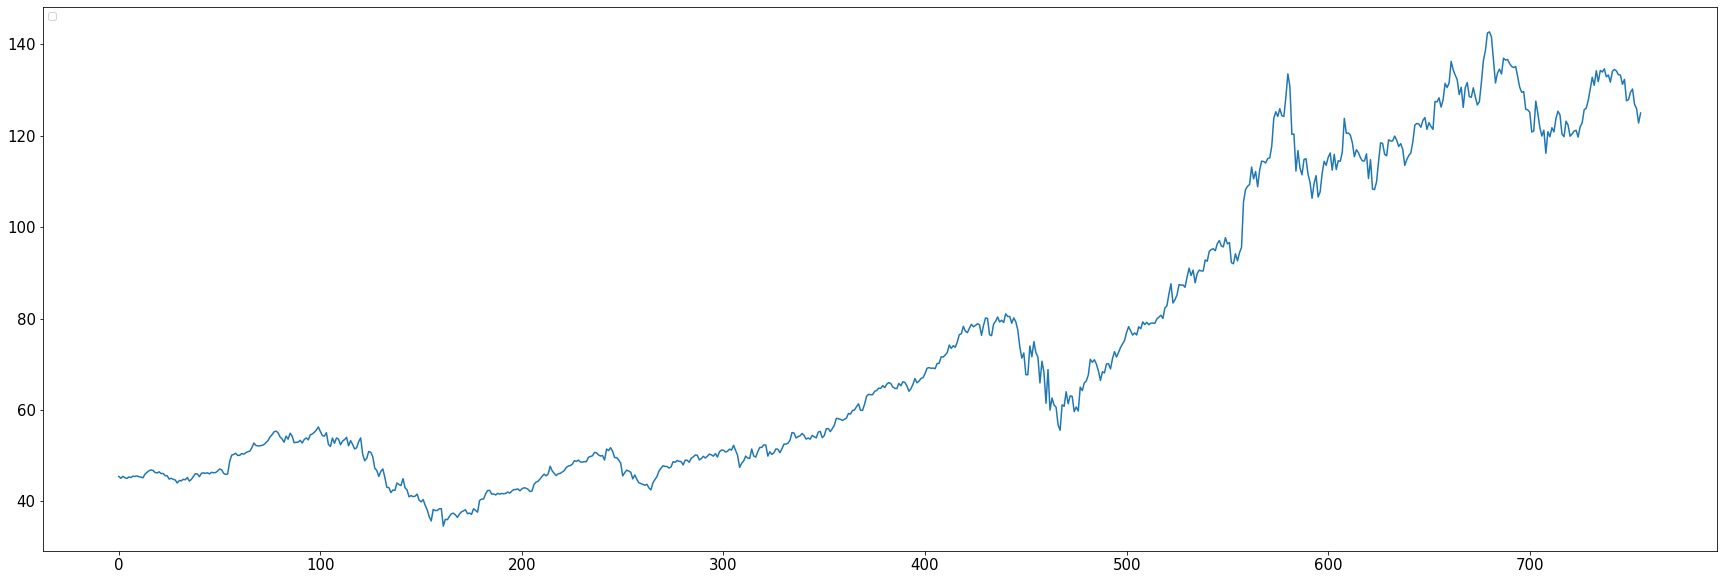

In [4]:
#Initial Visualization

fig = plt.figure(figsize=(30,10))
ax = plt.axes()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.plot(df.index, df['AdjClose'])
plt.legend(loc='upper left')

In [5]:
def deviation_stats(df):
    f_t = df['AdjClose'].to_numpy()
    f_t = f_t.flatten()
    window = 15
    mode = 'same'
    g_t = np.ones(int(window))/float(window)
    rolling_mean = np.convolve(f_t, g_t, mode)
    
    df['mean_count'] = rolling_mean
    df['residual'] = df.iloc[:,0] - rolling_mean
    std_resid = np.std(df.residual)
    df['pos_std'] = df.mean_count + std_resid
    df['neg_std'] = df.mean_count - std_resid
    df['pos_std_2'] = df.mean_count + 2*std_resid
    df['neg_std_2'] = df.mean_count - 2*std_resid
    return df

In [6]:
df2 = df[['AdjClose']]
df1 = deviation_stats(df2)
df1

,AdjClose,mean_count,residual,pos_std,neg_std,pos_std_2,neg_std_2
0,45.479355,24.159294,21.320061,28.307260,20.011327,32.455227,15.863360
1,45.066021,27.191251,17.874770,31.339217,23.043284,35.487184,18.895317
2,45.486610,30.230137,15.256473,34.378104,26.082170,38.526071,21.934204
3,45.198963,33.258065,11.940898,37.406032,29.110099,41.553999,24.962132
4,45.034599,36.279548,8.755052,40.427514,32.131581,44.575481,27.983614
...,...,...,...,...,...,...,...
751,130.210007,103.060366,27.149641,107.208333,98.912399,111.356299,94.764432
752,126.849998,94.170133,32.679865,98.318100,90.022167,102.466067,85.874200
753,125.910004,85.286556,40.623448,89.434523,81.138589,93.582489,76.990623
754,122.769997,76.537417,46.232580,80.685383,72.389450,84.833350,68.241483


Text(0.5, 1.0, 'Distribution of Residuals')

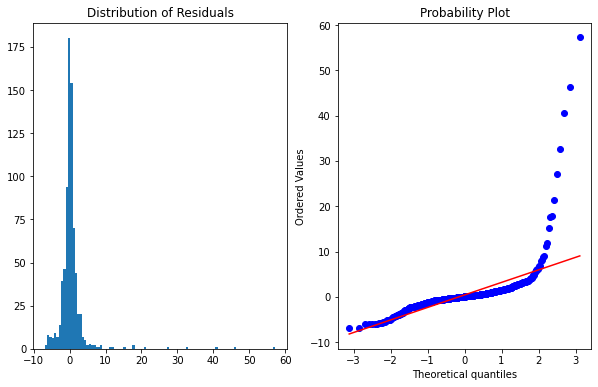

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
x = df1.residual.values
re = stats.probplot(x, plot=ax2)
ax1.hist(df1.residual, bins=100)
ax1.set_title('Distribution of Residuals')

In [8]:
max_outliers = int((df.AdjClose.count()*5)/100)
esd_outlier_index = esd_test(df[['AdjClose']], max_outliers)


In [9]:
anoma_points = pd.DataFrame(df[['AdjClose']].iloc[esd_outlier_index, 0].sort_index())
anoma_points

,AdjClose
0,45.479355
1,45.066021
2,45.486610
3,45.198963
580,133.522247
581,130.755875
584,112.266953
679,142.464767
752,126.849998
753,125.910004


Text(0.5, 1.0, 'Data with Anomalies starred')

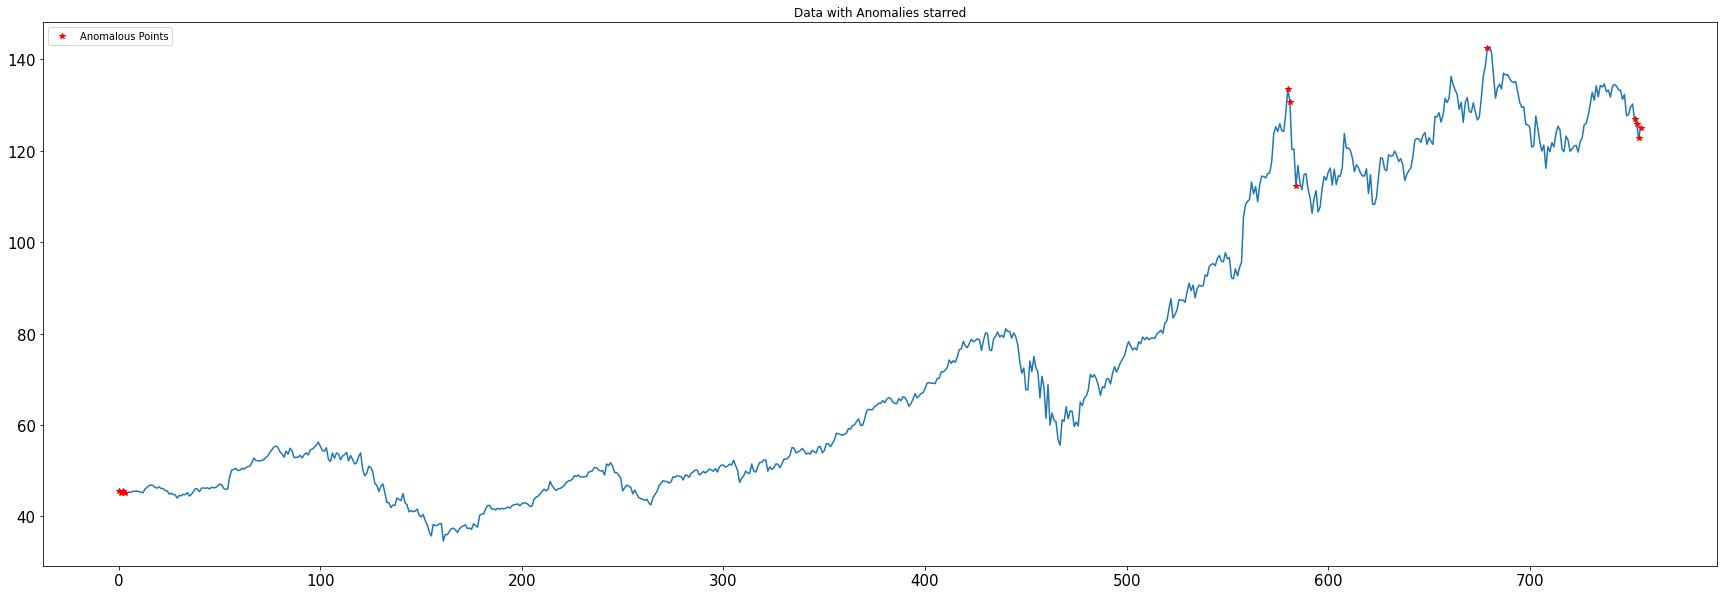

In [10]:
fig = plt.figure(figsize=(30,10))
ax = plt.axes()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.plot(df.index, df['AdjClose'])
ax.plot(list(anoma_points.index),anoma_points.iloc[:,0],'r*', label='Anomalous Points')
plt.legend(loc='upper left')
ax.set_title('Data with Anomalies starred')